<a href="https://colab.research.google.com/github/MaryamCodeHub/-Global-Video-Game-Market-Analysis/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'ravdess-emotional-speech-audio' dataset.
Path to dataset files: /kaggle/input/ravdess-emotional-speech-audio


In [43]:
import os
import librosa
import numpy as np
import soundfile
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Load Dataset

In [44]:
# 1. Emotion mapping
emotions = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}
observed_emotions = list(emotions.values())  # keep all emotions

# Feature Extraction

In [45]:
def extract_features(file_path, mfcc=True, chroma=True, mel=True):
    try:
        y, sr = librosa.load(file_path, sr=None)

        if len(y) < 2048:  # skip corrupted/too short files
            return None

        result = np.array([])

        if mfcc:
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
            mfccs = np.mean(mfccs.T, axis=0)
            result = np.hstack((result, mfccs))

        if chroma:
            stft = np.abs(librosa.stft(y=y))
            chroma_feat = librosa.feature.chroma_stft(S=stft, sr=sr)
            chroma_feat = np.mean(chroma_feat.T, axis=0)
            result = np.hstack((result, chroma_feat))

        if mel:
            mel_feat = librosa.feature.melspectrogram(y=y, sr=sr)
            mel_feat = np.mean(mel_feat.T, axis=0)
            result = np.hstack((result, mel_feat))

        return result

    except Exception as e:
        print(f"⚠️ Error extracting {file_path}: {e}")
        return None


# Load Data

In [46]:
def load_data(dataset_path):
    X, y = [], []
    skipped = 0

    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".wav"):   # only process wav files
                file_path = os.path.join(root, file)
                try:
                    emotion_id = file.split("-")[2]
                    emotion = emotions.get(emotion_id)

                    if emotion in observed_emotions:
                        feature = extract_features(file_path)
                        if feature is not None:
                            X.append(feature)
                            y.append(emotion)
                        else:
                            skipped += 1
                except Exception as e:
                    print(f"⚠️ Error processing {file_path}: {e}")
                    skipped += 1

    print(f"✅ Loaded {len(X)} samples, Skipped {skipped} files.")
    return np.array(X), np.array(y)


In [47]:
dataset_path = path
X, y = load_data(dataset_path)

print("Features shape:", X.shape)
print("Labels shape:", y.shape)
print("Sample labels:", y[:10])


✅ Loaded 2880 samples, Skipped 0 files.
Features shape: (2880, 180)
Labels shape: (2880,)
Sample labels: ['surprised' 'neutral' 'disgust' 'disgust' 'neutral' 'fearful' 'sad'
 'neutral' 'calm' 'happy']


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [49]:
# Initialize and train the SVM model
svm_model = SVC(kernel='linear')  # You can experiment with different kernels
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

Accuracy: 0.65625

Classification Report:
               precision    recall  f1-score   support

       angry       0.81      0.83      0.82        87
        calm       0.65      0.73      0.69        84
     disgust       0.56      0.67      0.61        75
     fearful       0.62      0.73      0.67        62
       happy       0.74      0.57      0.64        69
     neutral       0.58      0.43      0.49        35
         sad       0.61      0.54      0.57        89
   surprised       0.65      0.64      0.64        75

    accuracy                           0.66       576
   macro avg       0.65      0.64      0.64       576
weighted avg       0.66      0.66      0.65       576



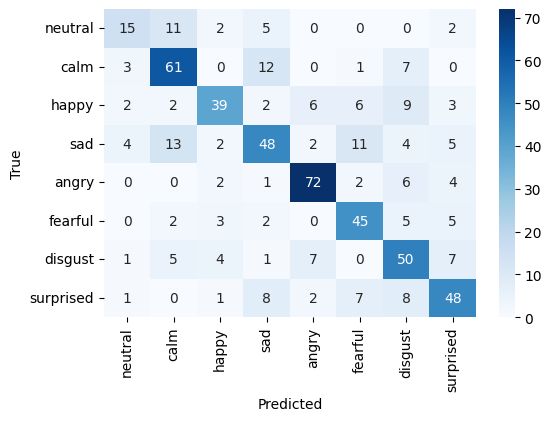

In [50]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=observed_emotions)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=observed_emotions, yticklabels=observed_emotions)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()